# Baseline Architecture
* test qdanalysis package functions
* rough out ML process

In [1]:
#auto reloading magic
%load_ext autoreload
%autoreload 2

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import qdanalysis.preprocessing.strokedecomposition as sd
from qdanalysis.models import adapt_resnet50

this is going to have to be done on a per file basis via path

In [2]:
#test data
eng_test = cv.imread(r'CERUG_EN_Test.png', cv.IMREAD_GRAYSCALE)
eng_test_bin = cv.threshold(eng_test, 0, 1, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1] #threshold and invert image at the same time

C:\Users\JUDE\AppData\Local\Temp\ipykernel_21356\1345006509.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


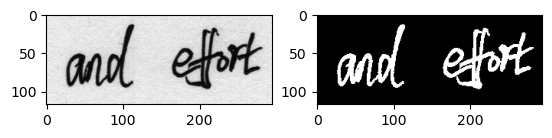

In [3]:
fig = plt.figure()
eng_ax = plt.subplot(1, 2, 1)
eng_ax.imshow(eng_test, cmap='gray')
eng_bin_Ax = plt.subplot(1, 2, 2)
eng_bin_Ax.imshow(eng_test_bin, cmap='gray')
fig.show()

In [4]:
test = sd.simple_stroke_segment(eng_test_bin)
len(test)

53

C:\Users\JUDE\AppData\Local\Temp\ipykernel_21356\3557466613.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  stroke_fig.show()


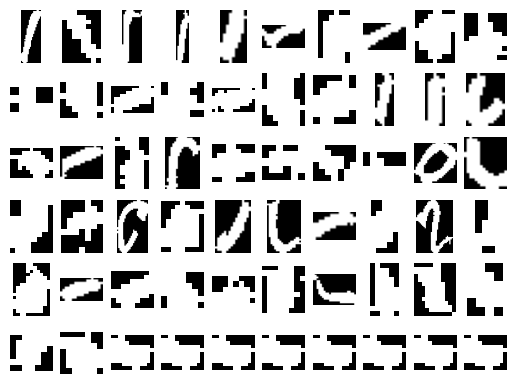

In [5]:
stroke_fig, stroke_axes = plt.subplots(6, 10)
count = 0
for row in stroke_axes:
    for ax in row:
        ax.axis('off')
        ax.imshow(test[count], cmap='gray')
        count = min(count+1, len(test)-1)

stroke_fig.show()

In [6]:
model = adapt_resnet50((64, 64, 3))
model.compile()

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dense_1 (Dense)             (None, 10)                10010     
                                                                 
Total params: 25,646,722
Trainable params: 2,059,010
Non-trainable params: 23,587,712
_________________________________________

In [31]:
height, width = test[0].shape
height, width

h = w = 64
h_d = h - height
w_d = h - width

top, bottom = h_d // 2, h_d - (h_d // 2)
top, bottom

left, right = w_d // 2, w_d - (w_d // 2)
left, right

test_padded = cv.copyMakeBorder(test[0].astype(float), top, bottom, left, right, cv.BORDER_CONSTANT, value = 0)
test_padded = cv.cvtColor(test_padded.astype(np.float32), cv.COLOR_GRAY2RGB)

In [32]:
test_padded.shape

(64, 64, 3)

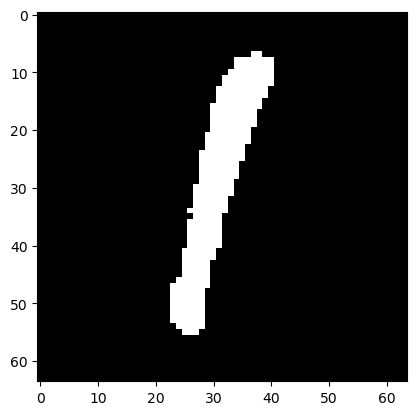

In [33]:
plt.imshow(test_padded)

In [36]:
fake_batch = test_padded.reshape(-1, 64, 64, 3)
model.predict(fake_batch)

1/1 [==============================] - 1s 1s/step


array([[0.03592583, 0.10540705, 0.14525512, 0.09030343, 0.16616838,
        0.05738817, 0.04139612, 0.06358203, 0.13849294, 0.15608098]],
      dtype=float32)